In [1]:
import ast
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy import random
import numpy as np
import sqlite3

In [2]:
conn = sqlite3.connect('../data/c4_sample.db')
c = conn.cursor()

In [3]:
rows = c.execute('SELECT google_classifier, n_tokens, bigrams_bnc, bigrams_cord19, content FROM c4_sample WHERE google_classifier IS NOT NULL').fetchall()

In [4]:
def sort_dict(dic):
    return {k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}

In [6]:
cat_count = defaultdict(int)
supercat_count = defaultdict(int)
supercat_tokens = defaultdict(list)
supercat_bigrams_bnc = defaultdict(list)
supercat_bigrams_cord19 = defaultdict(list)
supercat_filtered = defaultdict(int)

token_list = []
category_list = []
bigrams_bnc_list = []
content_list = []
for row in rows:
    classification = ast.literal_eval(row[0]) # read string of dict as python dict
    
    # Couldn't be classified -> skip
    if len(classification) == 0:
        cat_count['Failed'] += 1
        supercat_count['Failed'] += 1
        supercat_tokens['Failed'].append(row[1])
        supercat_bigrams_bnc['Failed'].append(row[2])
        supercat_bigrams_cord19['Failed'].append(row[3])
        if row[2] > 10_000:
            supercat_filtered['Failed'] += 1
        
        category_list.append('Failed')
        bigrams_bnc_list.append(row[2])
        content_list.append(row[4])
        token_list.append(0)
        continue

    # Category with highest probability
    row_cat = next(iter(sort_dict(classification)))
    row_supercat = [subcat for subcat in row_cat.split('/') if subcat][0]

    # count occurances
    cat_count[row_cat] += 1
    supercat_count[row_supercat] += 1

    if row[2] > 10_000:
        supercat_filtered[row_supercat] += 1

    supercat_tokens[row_supercat].append(row[1])
    supercat_bigrams_bnc[row_supercat].append(row[2])
    supercat_bigrams_cord19[row_supercat].append(row[2])

    category_list.append(row_supercat)
    token_list.append(row[1])
    bigrams_bnc_list.append(row[2])
    content_list.append(row[4])

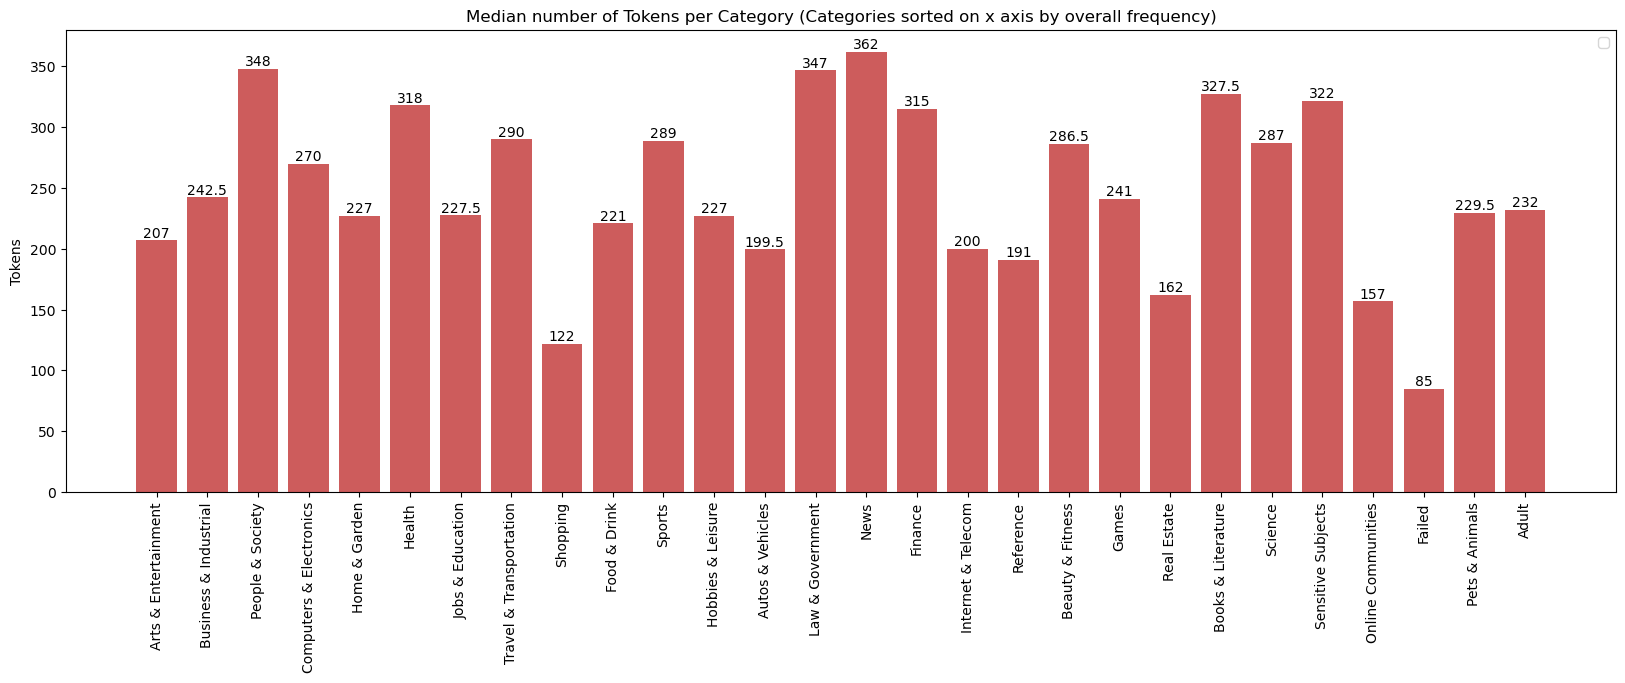

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.xticks(rotation=90)
xlocs, xlabs = plt.xticks()
for i, (category, amount) in enumerate(sort_dict(supercat_count).items()):    
    ax.bar(category, round(np.median(supercat_tokens[category]),2), color='indianred')
    ax.bar_label(ax.containers[i], label_type='edge')

handles, labels = ax.get_legend_handles_labels()
#handles.append(mpatches.Patch(color='none', label=f"Overall mean: {tokens_mean}"))
plt.title("Median number of Tokens per Category (Categories sorted on x axis by overall frequency)")
ax.legend(handles=handles)
ax.set_ylabel("Tokens")
plt.show()

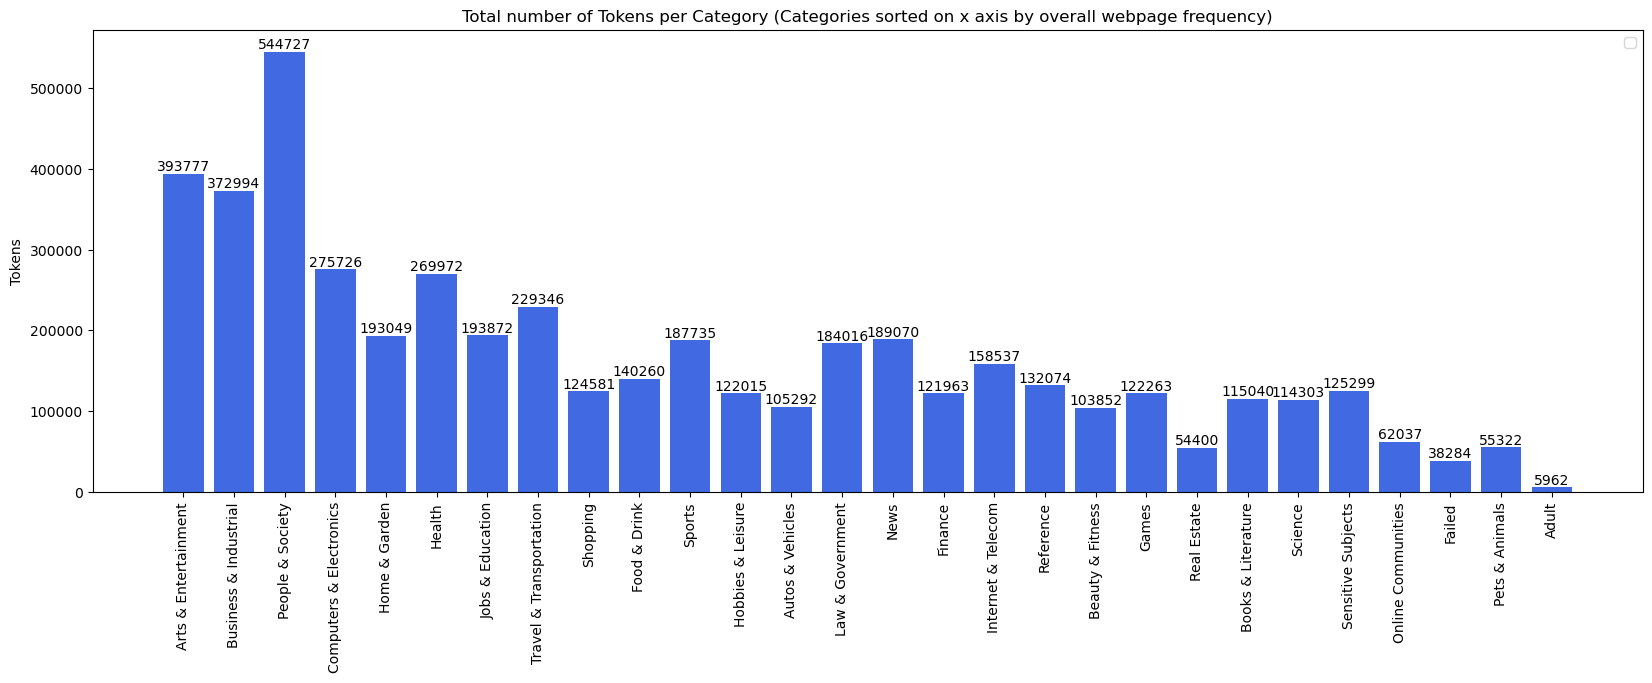

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.xticks(rotation=90)
xlocs, xlabs = plt.xticks()
for i, (category, amount) in enumerate(sort_dict(supercat_count).items()):    
    ax.bar(category, np.sum(supercat_tokens[category]), color='royalblue')
    ax.bar_label(ax.containers[i], label_type='edge')

handles, labels = ax.get_legend_handles_labels()
#handles.append(mpatches.Patch(color='none', label=f"Overall mean: {tokens_mean}"))
plt.title("Total number of Tokens per Category (Categories sorted on x axis by overall webpage frequency)")
ax.legend(handles=handles)
ax.set_ylabel("Tokens")
plt.show()

In [9]:
bigrams_bnc = [item for sublist in [v for k, v in supercat_bigrams_bnc.items()] for item in sublist]
bigrams_cord19 = [item for sublist in [v for k, v in supercat_bigrams_cord19.items()] for item in sublist]

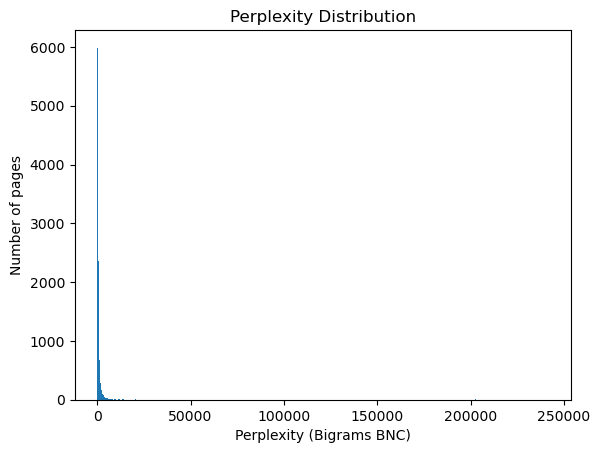

In [10]:
plt.hist(bigrams_bnc, bins=500)
plt.title("Perplexity Distribution")
plt.ylabel("Number of pages")
plt.xlabel("Perplexity (Bigrams BNC)");

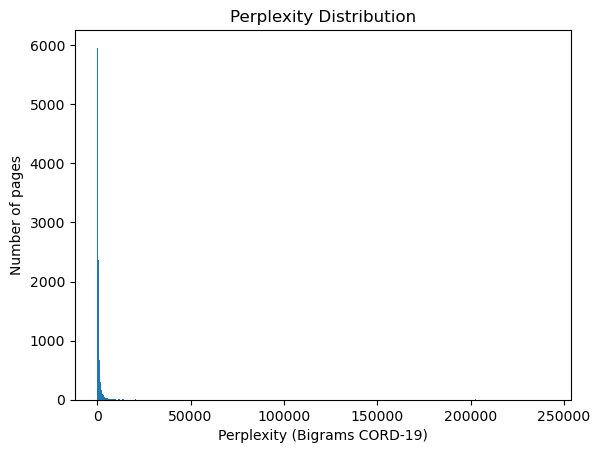

In [11]:
plt.hist(bigrams_cord19, bins=500)
plt.title("Perplexity Distribution")
plt.ylabel("Number of pages")
plt.xlabel("Perplexity (Bigrams CORD-19)");

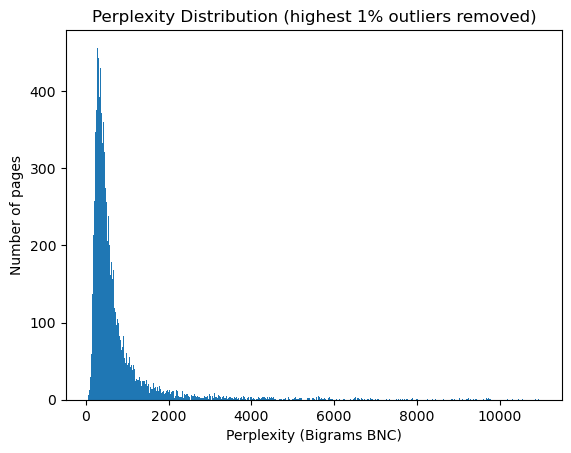

In [12]:
plt.hist(sorted(bigrams_bnc)[:-100], bins=500)
plt.title("Perplexity Distribution (highest 1% outliers removed)")
plt.ylabel("Number of pages")
plt.xlabel("Perplexity (Bigrams BNC)");

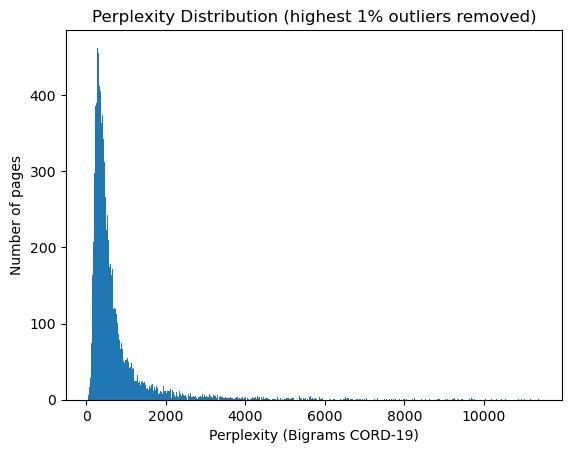

In [13]:
plt.hist(sorted(bigrams_cord19)[:-100], bins=500)
plt.title("Perplexity Distribution (highest 1% outliers removed)")
plt.ylabel("Number of pages")
plt.xlabel("Perplexity (Bigrams CORD-19)");

In [14]:
tokens = [item for sublist in [v for k, v in supercat_tokens.items()] for item in sublist]

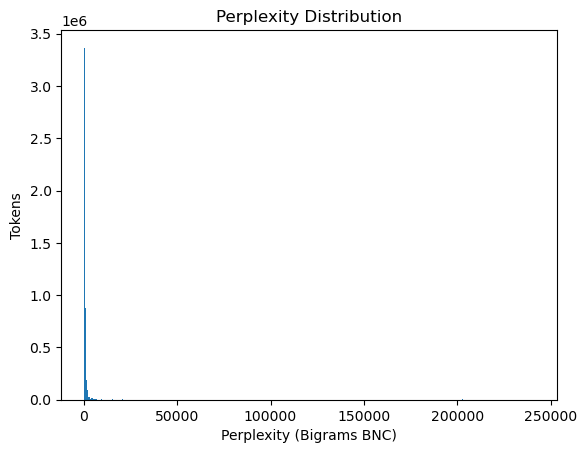

In [15]:
plt.hist(bigrams_bnc, bins=500, weights=tokens)
plt.title("Perplexity Distribution")
plt.ylabel("Tokens")
plt.xlabel("Perplexity (Bigrams BNC)");

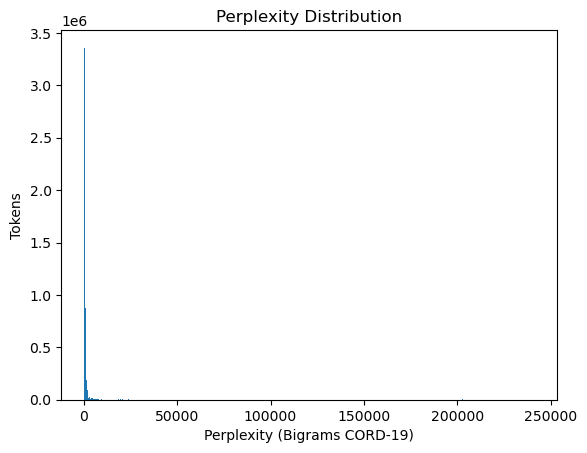

In [16]:
plt.hist(bigrams_cord19, bins=500, weights=tokens)
plt.title("Perplexity Distribution")
plt.ylabel("Tokens")
plt.xlabel("Perplexity (Bigrams CORD-19)");

In [17]:
zipped_bnc = sorted(zip(bigrams_bnc, tokens))
bnc = [p for p,_ in zipped_bnc]
token = [t for _,t in zipped_bnc]

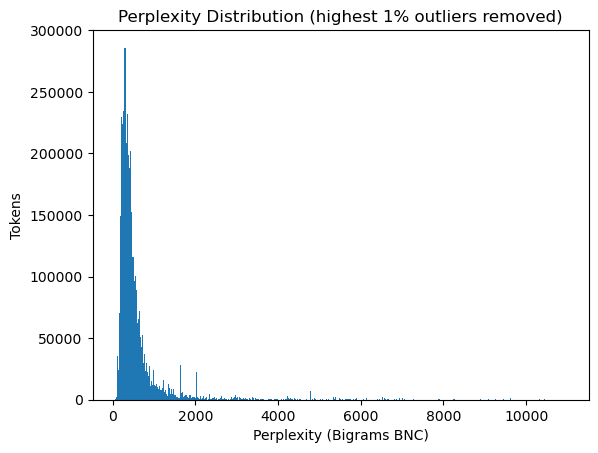

In [18]:
plt.hist(bnc[:-100], bins=500, weights=token[:-100])
plt.title("Perplexity Distribution (highest 1% outliers removed)")
plt.ylabel("Tokens")
plt.xlabel("Perplexity (Bigrams BNC)");

In [19]:
zipped_cord19 = sorted(zip(bigrams_cord19, tokens))
cord19 = [p for p,_ in zipped_cord19]
token = [t for _,t in zipped_cord19]

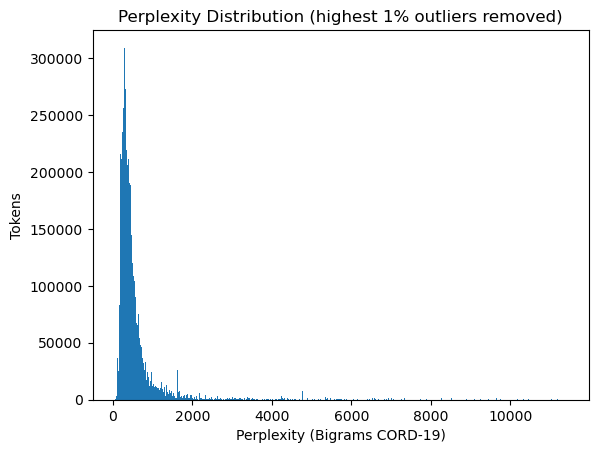

In [20]:
plt.hist(cord19[:-100], bins=500, weights=token[:-100])
plt.title("Perplexity Distribution (highest 1% outliers removed)")
plt.ylabel("Tokens")
plt.xlabel("Perplexity (Bigrams CORD-19)");

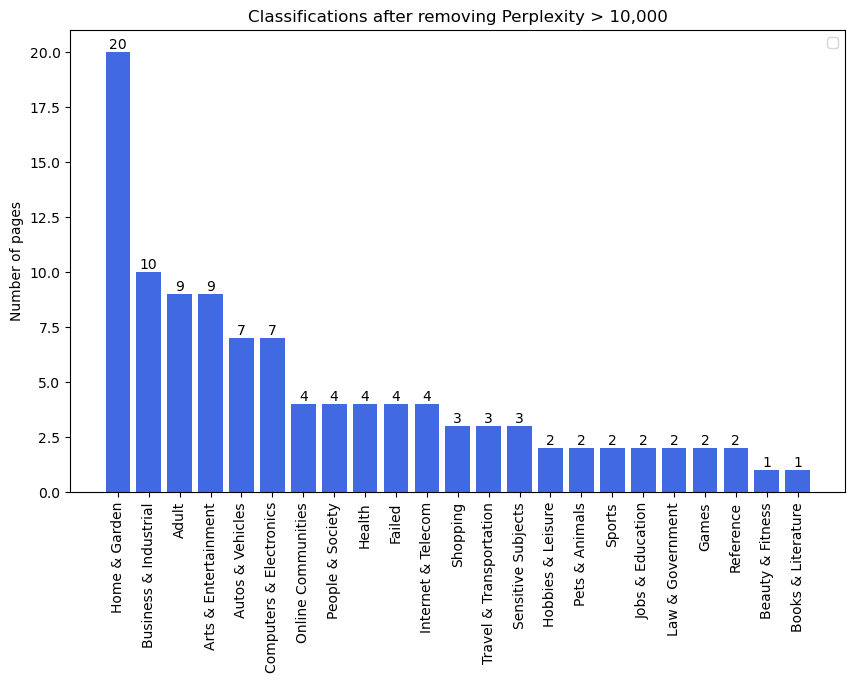

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90)
xlocs, xlabs = plt.xticks()
for i, (category, amount) in enumerate(sort_dict(supercat_filtered).items()):    
    ax.bar(category, amount, color='royalblue')
    ax.bar_label(ax.containers[i], label_type='edge')

handles, labels = ax.get_legend_handles_labels()
#handles.append(mpatches.Patch(color='none', label=f"Overall mean: {tokens_mean}"))
plt.title("Classifications after removing Perplexity > 10,000")
ax.legend(handles=handles)
ax.set_ylabel("Number of pages")
plt.show()

In [22]:
import pandas as pd

In [23]:
df_count = pd.DataFrame.from_dict(supercat_count, orient='index', columns=['Total Count'])
df_filtered = pd.DataFrame.from_dict(supercat_filtered, orient='index', columns=['Removed'])
df_merge = pd.concat([df_filtered, df_count], axis=1, join="outer")

df_merge = df_merge.fillna(0)

df_merge['Percent Removed'] = df_merge['Removed'] / df_merge['Total Count'] * 100

df_merge.sort_values('Removed', ascending=False)

,Removed,Total Count,Percent Removed
Home & Garden,20.0,519,3.853565
Business & Industrial,10.0,830,1.204819
Adult,9.0,25,36.000000
Arts & Entertainment,9.0,1015,0.886700
Autos & Vehicles,7.0,300,2.333333
Computers & Electronics,7.0,569,1.230228
Online Communities,4.0,185,2.162162
People & Society,4.0,727,0.550206
Health,4.0,515,0.776699
Failed,4.0,135,2.962963


In [24]:
df_describe_cord19 = pd.DataFrame(bigrams_cord19)
df_describe_cord19.describe()

,0
count,10000.000000
mean,1229.981371
std,7719.735482
min,58.334429
25%,308.999541
50%,456.758001
75%,764.016927
max,241604.029722


In [25]:
df_describe_bnc = pd.DataFrame(bigrams_bnc)
df_describe_bnc.describe()

,0
count,10000.000000
mean,1220.796189
std,7721.074256
min,58.334429
25%,308.199629
50%,454.852496
75%,756.871644
max,241604.029722


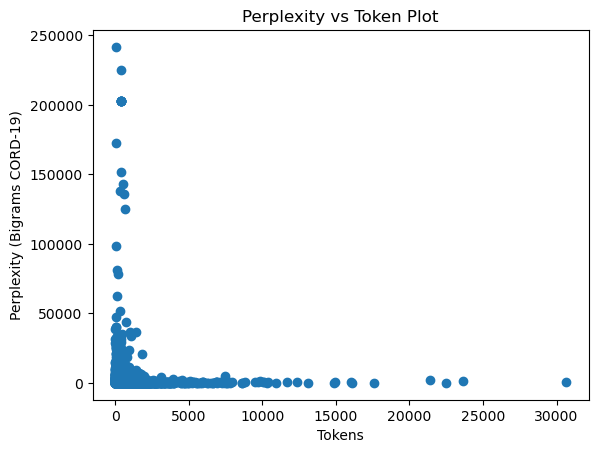

In [30]:
df = pd.DataFrame({'category': category_list, 'content': content_list, 'bbnc': bigrams_bnc_list, 'tokens': token_list})

plt.scatter(x=token_list, y=bigrams_bnc_list)
plt.title("Perplexity vs Token Plot")
plt.ylabel("Perplexity (Bigrams CORD-19)")
plt.xlabel("Tokens");